In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sqlite3
import sys
import logging
import pickle

# Data
from sklearn.model_selection import train_test_split

# Tensorflow
import tensorflow as tf

# Graph
import tensorflow_gnn as tfgnn

# Add the project root to the Python path
#sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from scripts.data_cleaner import filter_top_cpv_categories
#from scripts.gnn_anomaly_detection import ProcurementGraphBuilder, GNNAnomalyDetector, AnomalyAnalyzer
from scripts.gnn_anomaly_detection_v2 import ProcurementGraphBuilder, GNNAnomalyDetector, AnomalyAnalyzer

from scripts.synthetic_anomaly_generator_v2 import SyntheticAnomalyGenerator

from scripts.preprocess_pipeline import create_pipeline_cat


%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
data_path = os.path.join(os.path.dirname(os.getcwd()), 'data')
df = pd.read_csv(os.path.join(data_path, 'data_clean.csv'))
df.head()

,uid,id,nature,acheteur_id,acheteur_nom,acheteur_siren,titulaire_id,titulaire_typeIdentifiant,titulaire_nom,titulaire_siren,...,lieuExecution_typeCode,idAccordCadre,source_open_data,codeCPV_FR,codeCPV_2,codeCPV_3,codeCPV_4,codeCPV_5,codeCPV_2_3,annee
0,210601209000132022_M013,2022_M013,Marché,21060120900013,COMMUNE DE SAINT ETIENNE DE TINEE,210601209.0,38177692100029,SIRET,SERMATECH,381776921.0,...,Code postal,NaN,data.gouv.fr decp-2024.json,Travaux de construction de bâtiments,45000000,45200000,45210000,45210000,45200000,2021
1,217100759000182024RENOCHARP,2024RENOCHARP,Marché,21710075900018,COMMUNE DE CHALMOUX,217100759.0,75203574100038,SIRET,MACON ETANCHEITE,752035741.0,...,Code postal,NaN,data.gouv.fr decp-2025-01.json,Travaux de charpente et de couverture et trava...,45000000,45200000,45260000,45261000,45200000,2023
2,200066231000162022033INFOL00,2022033INFOL00,Marché,20006623100016,CC DES PORTES D'ARIEGE PYRENEES,200066231.0,49459697600014,SIRET,EQUADEX,494596976.0,...,Code postal,2022033INFOL00,data.gouv.fr decp-2024.json,Services de gestion d'installations pour le dé...,72000000,72500000,72510000,72514000,72000000,2023
3,243100518001702024M05,2024M05,Marché,24310051800170,TOULOUSE METROPOLE,243100518.0,59278023300017,SIRET,RIVES & EAUX DU SUD-OUEST,592780233.0,...,Code postal,NaN,data.gouv.fr decp-2025-04.json,Services d'ingénierie,71000000,71300000,71300000,71300000,71300000,2024
4,21590544900017202402401,202402401,Marché,21590544900017,COMMUNE DE SAINT SAULVE,215905449.0,32683156700010,SIRET,ALTOMARE ALTALU,326831567.0,...,Code postal,NaN,data.gouv.fr decp-2024.json,Serrurerie,44000000,44300000,44310000,44316000,44000000,2024


In [19]:
generator = SyntheticAnomalyGenerator(random_seed=42)

df_sample = df.copy()

# Generate anomalies
df_with_anomalies, anomaly_labels = generator.generate_anomalies(
        df_sample,
        anomaly_percentage=0.10,  # 10% anomalies
        anomaly_types=['single_bid_competitive', 'high_market_concentration' ,  
                       'price_manipulation', 'procedure_manipulation',
                       'suspicious_modifications', 'temporal_clustering',
                       'excessive_subcontracting', 'unusual_contract_duration',
                       'suspicious_buyer_supplier_pairs']
    )

df_with_anomalies.head()

INFO:scripts.synthetic_anomaly_generator_v2:Generating 28685 total synthetic anomaly rows
INFO:scripts.synthetic_anomaly_generator_v2:Approximately 3187 anomalies per type
INFO:scripts.synthetic_anomaly_generator_v2:Generating single_bid_competitive anomalies...
INFO:scripts.synthetic_anomaly_generator_v2:Generated 3187 single bid competitive anomaly rows
INFO:scripts.synthetic_anomaly_generator_v2:Generating price_manipulation anomalies...
INFO:scripts.synthetic_anomaly_generator_v2:Generated 3187 price manipulation anomaly rows
INFO:scripts.synthetic_anomaly_generator_v2:Generating procedure_manipulation anomalies...
INFO:scripts.synthetic_anomaly_generator_v2:Generated 3187 procedure manipulation anomaly rows
INFO:scripts.synthetic_anomaly_generator_v2:Generating suspicious_modifications anomalies...
INFO:scripts.synthetic_anomaly_generator_v2:Generated 3187 suspicious modification anomaly rows
INFO:scripts.synthetic_anomaly_generator_v2:Generated 12748 total synthetic anomaly rows


,uid,id,nature,acheteur_id,acheteur_nom,acheteur_siren,titulaire_id,titulaire_typeIdentifiant,titulaire_nom,titulaire_siren,...,codeCPV_FR,codeCPV_2,codeCPV_3,codeCPV_4,codeCPV_5,codeCPV_2_3,annee,anomaly_type,source_type,is_synthetic_anomaly
0,210601209000132022_M013,2022_M013,Marché,21060120900013,COMMUNE DE SAINT ETIENNE DE TINEE,210601209.0,38177692100029,SIRET,SERMATECH,381776921.0,...,Travaux de construction de bâtiments,45000000,45200000,45210000,45210000,45200000,2021,NaN,NaN,False
1,217100759000182024RENOCHARP,2024RENOCHARP,Marché,21710075900018,COMMUNE DE CHALMOUX,217100759.0,75203574100038,SIRET,MACON ETANCHEITE,752035741.0,...,Travaux de charpente et de couverture et trava...,45000000,45200000,45260000,45261000,45200000,2023,NaN,NaN,False
2,200066231000162022033INFOL00,2022033INFOL00,Marché,20006623100016,CC DES PORTES D'ARIEGE PYRENEES,200066231.0,49459697600014,SIRET,EQUADEX,494596976.0,...,Services de gestion d'installations pour le dé...,72000000,72500000,72510000,72514000,72000000,2023,NaN,NaN,False
3,243100518001702024M05,2024M05,Marché,24310051800170,TOULOUSE METROPOLE,243100518.0,59278023300017,SIRET,RIVES & EAUX DU SUD-OUEST,592780233.0,...,Services d'ingénierie,71000000,71300000,71300000,71300000,71300000,2024,NaN,NaN,False
4,21590544900017202402401,202402401,Marché,21590544900017,COMMUNE DE SAINT SAULVE,215905449.0,32683156700010,SIRET,ALTOMARE ALTALU,326831567.0,...,Serrurerie,44000000,44300000,44310000,44316000,44000000,2024,NaN,NaN,False


In [ ]:
graph_builder = ProcurementGraphBuilder()

data_path = os.path.join(os.path.dirname(os.getcwd()), 'data')

df = graph_builder.load_data(data_path)

X_train_preproc, X_val_preproc, X_test_preproc, X_train, X_val, X_test = graph_builder.preprocess_data(df)

X_train_graph = graph_builder.create_graph(X_train_preproc, X_train, type='train')
X_val_graph = graph_builder.create_graph(X_val_preproc, X_val, type='val')
X_test_graph = graph_builder.create_graph(X_test_preproc, X_test, type='test')

In [11]:
data_path = os.path.join(os.path.dirname(os.getcwd()), 'data')


# Load a pickle file
with open(os.path.join(data_path, 'graph_data_train.pkl'), 'rb') as f:
    X_train_graph = pickle.load(f)

with open(os.path.join(data_path, 'graph_data_val.pkl'), 'rb') as f:
    X_val_graph = pickle.load(f)

with open(os.path.join(data_path, 'graph_data_test.pkl'), 'rb') as f:
    X_test_graph = pickle.load(f)
    
gnn_detector = GNNAnomalyDetector(hidden_dim=64, output_dim=32, num_layers=3)

# Train graph
node_features_train = X_train_graph['node_features']
edge_features_train = X_train_graph['edge_features']

X_train_tf_graph = gnn_detector.create_tensorflow_graph(X_train_graph, node_features_train, edge_features_train)
gnn_detector.graph_tensor_train = X_train_tf_graph

# Val graph
node_features_val = X_val_graph['node_features']
edge_features_val = X_val_graph['edge_features']

X_val_tf_graph = gnn_detector.create_tensorflow_graph(X_val_graph, node_features_val, edge_features_val)
gnn_detector.graph_tensor_val = X_val_tf_graph

# Test graph
node_features_test = X_test_graph['node_features']
edge_features_test = X_test_graph['edge_features']

X_test_tf_graph = gnn_detector.create_tensorflow_graph(X_test_graph, node_features_test, edge_features_test)
gnn_detector.graph_tensor_test = X_test_tf_graph


INFO:scripts.gnn_anomaly_detection_2:Creating TensorFlow GNN graph...
INFO:scripts.gnn_anomaly_detection_2:Creating TensorFlow GNN graph...
INFO:scripts.gnn_anomaly_detection_2:Creating TensorFlow GNN graph...


# Edge anomalies

INFO:scripts.gnn_anomaly_detection_2:Building GNN model for edge anomaly detection...


INFO:scripts.gnn_anomaly_detection_2:Training edge GNN model for 100 epochs...


Epoch 1/100


1/1 [==============================] - 5s 5s/step - loss: 0.4628 - edge_embeddings_loss: 0.0556 - edge_reconstructed_loss: 0.5080 - val_loss: 0.1645 - val_edge_embeddings_loss: 0.3810 - val_edge_reconstructed_loss: 0.1404
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 0.4138 - edge_embeddings_loss: 0.0811 - edge_reconstructed_loss: 0.4508 - val_loss: 0.1500 - val_edge_embeddings_loss: 0.3050 - val_edge_reconstructed_loss: 0.1328
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 0.3820 - edge_embeddings_loss: 0.0907 - edge_reconstructed_loss: 0.4143 - val_loss: 0.1411 - val_edge_embeddings_loss: 0.2594 - val_edge_reconstructed_loss: 0.1280
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 0.3374 - edge_embeddings_loss: 0.0601 - edge_reconstructed_loss: 0.3682 - val_loss: 0.1339 - val_edge_embeddings_loss: 0.2293 - val_edge_reconstructed_loss: 0.1233
Epoch 5/100
1/1 [==============================] - 1s 974ms/step - loss: 0.3

/home/ronan/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.GraphTensorSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/home/ronan/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.ContextSpec.v2; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/home/ronan/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.NodeSetSpec; loading this Stru

INFO:tensorflow:Assets written to: /home/ronan/code/RonanB400/Project/decp_ml/data/gnn_edge_anomaly_model/assets


INFO:tensorflow:Assets written to: /home/ronan/code/RonanB400/Project/decp_ml/data/gnn_edge_anomaly_model/assets
INFO:scripts.gnn_anomaly_detection_2:Edge model saved to /home/ronan/code/RonanB400/Project/decp_ml/data/gnn_edge_anomaly_model


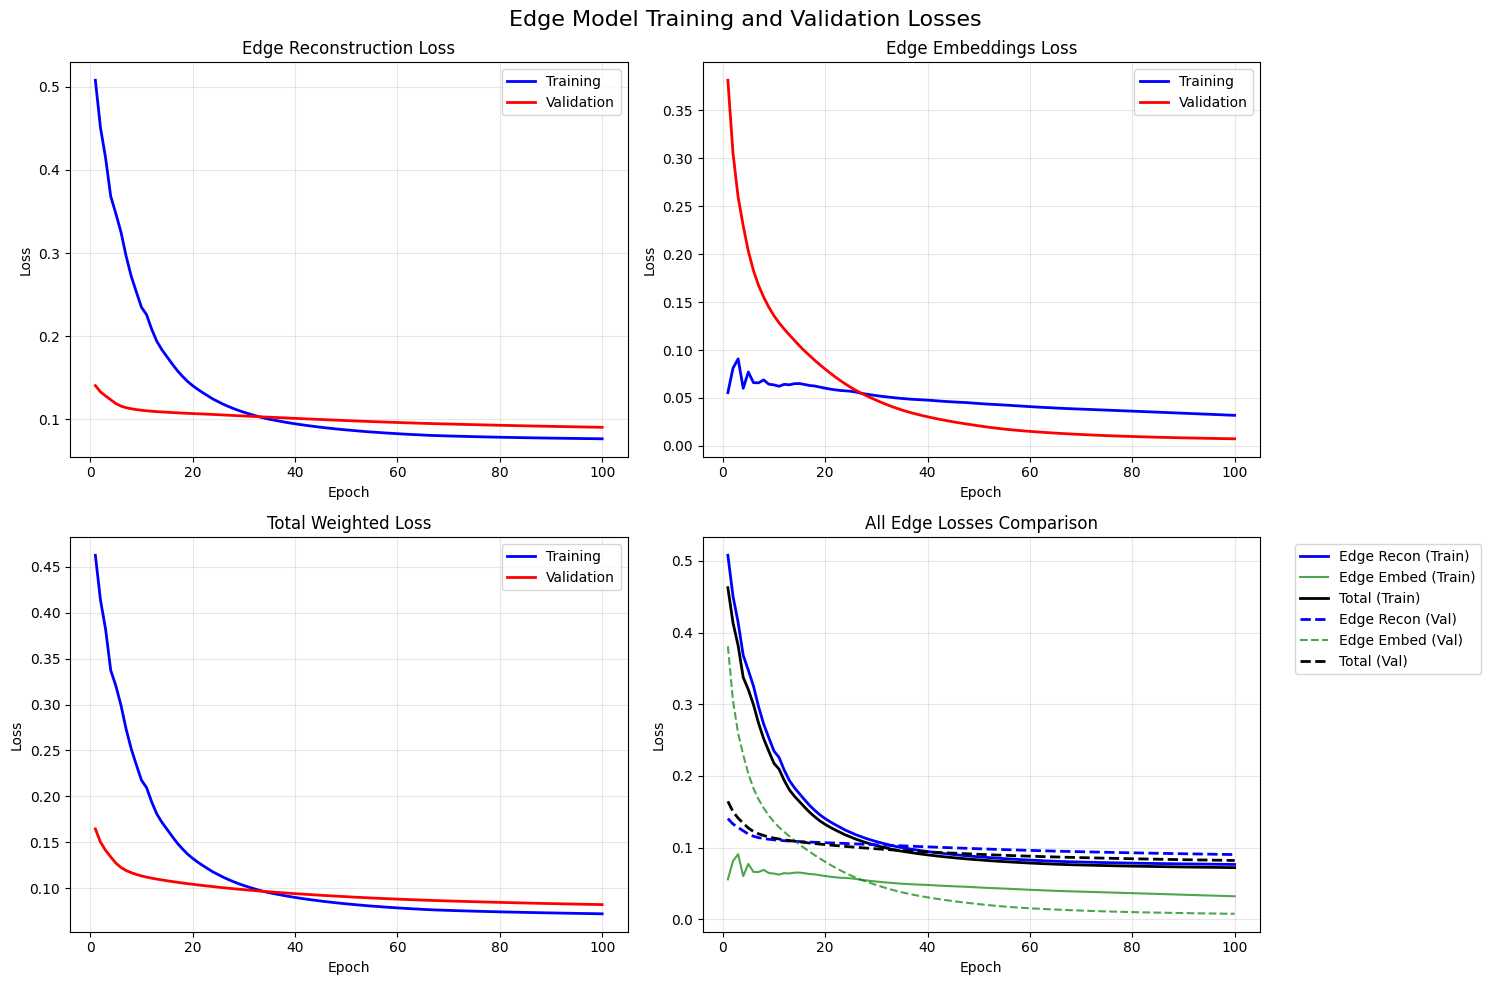


EDGE MODEL - FINAL LOSS VALUES
Training Losses (Final Epoch):
  - Edge Reconstruction: 0.076348
  - Edge Embeddings: 0.031938
  - Total Weighted Loss: 0.071907

Validation Losses (Final Epoch):
  - Edge Reconstruction: 0.090196
  - Edge Embeddings: 0.007492
  - Total Weighted Loss: 0.081926

Training vs Validation Analysis:
  - ⚠️  Potential overfitting (val loss >> train loss)
      Model memorizing training data, poor generalization


In [4]:
gnn_detector.edge_model = gnn_detector.build_edge_model(X_train_graph['node_features'].shape[1], X_train_graph['edge_features'].shape[1],
                                              l2_regularization=0, dropout_rate=0)

edge_history = gnn_detector.train_edge_model(X_train_tf_graph, 
                                        validation_graph_tensor=X_val_tf_graph, 
                                        epochs=100)

gnn_detector.plot_edge_training_history(edge_history)

# Edge anomalies

INFO:scripts.gnn_anomaly_detection_2:Building GNN model for node anomaly detection...
INFO:scripts.gnn_anomaly_detection_2:Training node GNN model for 50 epochs...


Epoch 1/50
1/1 [==============================] - 4s 4s/step - loss: 6.3327 - node_embeddings_loss: 0.0038 - node_reconstructed_loss: 7.0359 - val_loss: 1.0684 - val_node_embeddings_loss: 0.1559 - val_node_reconstructed_loss: 1.1697
Epoch 2/50
1/1 [==============================] - 1s 519ms/step - loss: 6.2162 - node_embeddings_loss: 0.0039 - node_reconstructed_loss: 6.9065 - val_loss: 1.0594 - val_node_embeddings_loss: 0.1086 - val_node_reconstructed_loss: 1.1651
Epoch 3/50
1/1 [==============================] - 1s 531ms/step - loss: 6.1348 - node_embeddings_loss: 0.0050 - node_reconstructed_loss: 6.8158 - val_loss: 1.0552 - val_node_embeddings_loss: 0.0837 - val_node_reconstructed_loss: 1.1631
Epoch 4/50
1/1 [==============================] - 1s 516ms/step - loss: 6.0221 - node_embeddings_loss: 0.0053 - node_reconstructed_loss: 6.6906 - val_loss: 1.0523 - val_node_embeddings_loss: 0.0670 - val_node_reconstructed_loss: 1.1618
Epoch 5/50
1/1 [==============================] - 1s 563ms/

/home/ronan/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.GraphTensorSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/home/ronan/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.ContextSpec.v2; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "
/home/ronan/.pyenv/versions/3.10.6/envs/decp_ml_env/lib/python3.10/site-packages/tensorflow/python/saved_model/nested_structure_coder.py:458: UserWarning: Encoding a StructuredValue with type tensorflow_gnn.NodeSetSpec; loading this Stru

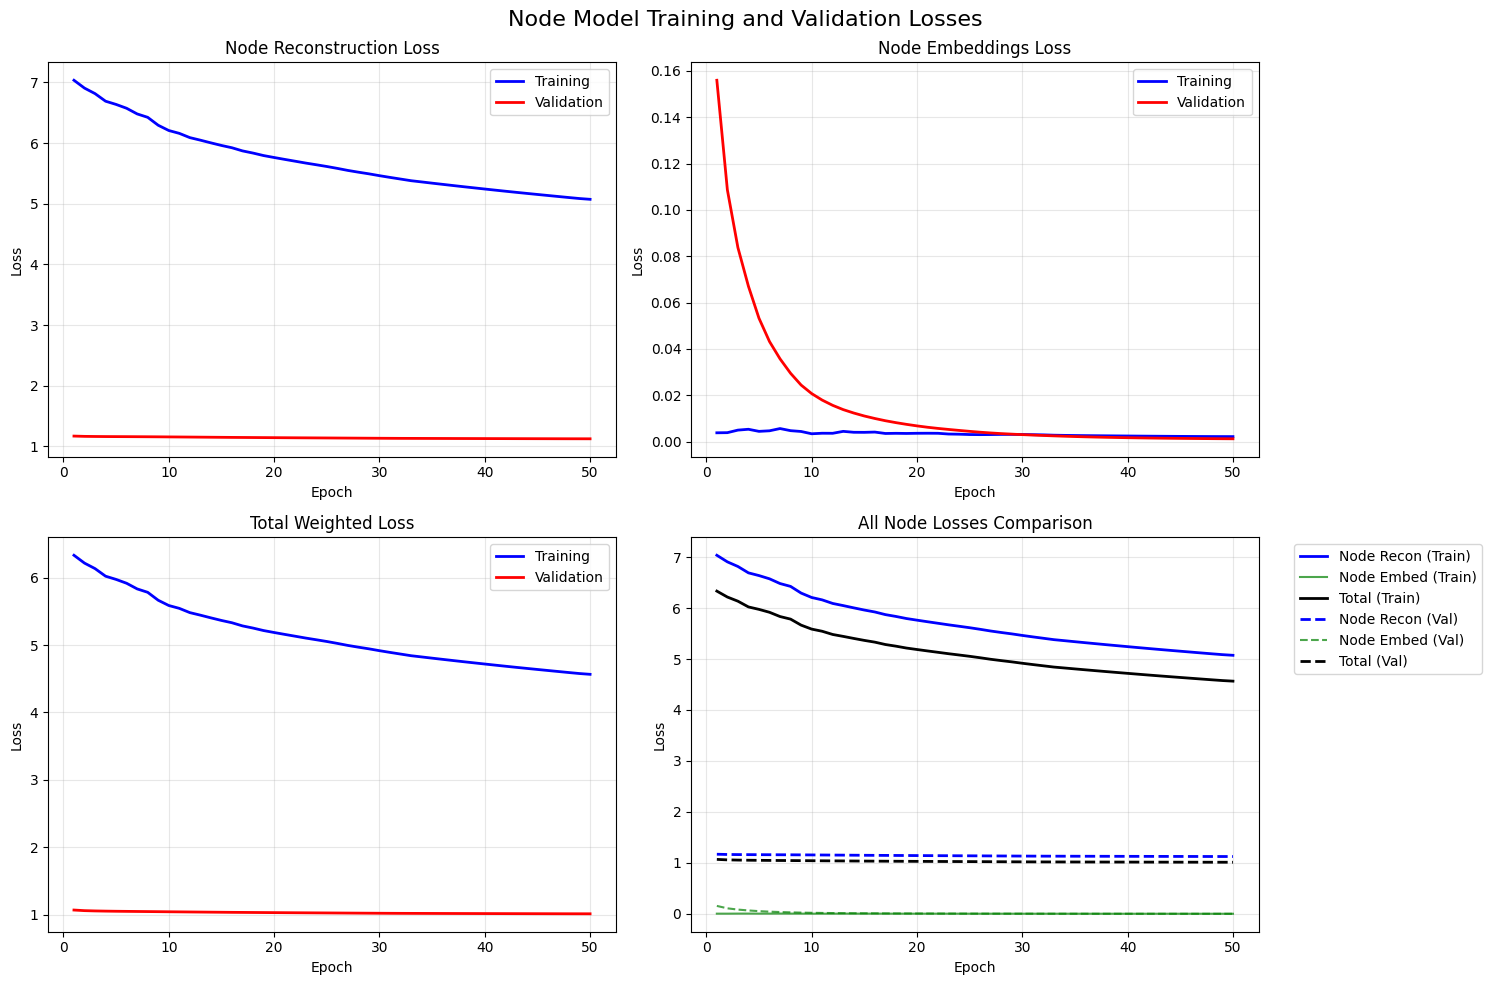


NODE MODEL - FINAL LOSS VALUES
Training Losses (Final Epoch):
  - Node Reconstruction: 5.073133
  - Node Embeddings: 0.002169
  - Total Weighted Loss: 4.566036

Validation Losses (Final Epoch):
  - Node Reconstruction: 1.124991
  - Node Embeddings: 0.001222
  - Total Weighted Loss: 1.012614

Training vs Validation Analysis:
  - ⚠️  Training loss >> Validation loss
      Likely causes: Dropout/regularization effects
      This is NOT overfitting - model performs better on validation!


In [13]:
gnn_detector.node_model = gnn_detector.build_node_model(X_train_graph['node_features'].shape[1], X_train_graph['edge_features'].shape[1],
                                              l2_regularization=0, dropout_rate=0)

node_history = gnn_detector.train_node_model(X_train_tf_graph, 
                                        validation_graph_tensor=X_val_tf_graph, 
                                        epochs=50)

gnn_detector.plot_node_training_history(node_history)

In [ ]:

(node_reconstruction_error, edge_reconstruction_error, 
     node_threshold, edge_threshold) = gnn_detector.detect_anomalies()
    
# Calculate anomaly masks
node_anomalies = node_reconstruction_error > node_threshold
edge_anomalies = edge_reconstruction_error > edge_threshold

In [ ]:
 #Create results analysis
graph_data = X_test_graph

analyzer = AnomalyAnalyzer()

node_results_df = analyzer.create_node_results_dataframe(
    graph_data, node_reconstruction_error, node_anomalies)

node_results_df.head()

In [ ]:
edge_results_df = analyzer.create_edge_results_dataframe(
    graph_data, edge_reconstruction_error, edge_anomalies)

edge_results_df.head()

In [ ]:
data_path

In [ ]:
model_path = os.path.join(data_path, 'gnn_anomaly_model.keras')

tf.saved_model.save(gnn_detector.model, model_path)

In [ ]:
graph_builder = ProcurementGraphBuilder()
graph_builder.visualize_procurement_graph(X_train_graph)